# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What do the reference and rating numbers represent? (Hint: read the dataset documentation and write down the interpretation for each number).

In [5]:
# YOUR CODE HERE
print(f"number of columns: {df.shape[1]}")
print(f"number of rows: {df.shape[0]}")
print(f"columns names: {df.columns.values}")

number of columns: 9
number of rows: 1795
columns names: ['maker' 'specific_origin' 'reference_number' 'review_date'
 'cocoa_percent' 'maker_location' 'rating' 'bean_type' 'broad_origin']


In [6]:
# Show # of unique values of each column in df
df.nunique()

maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64

**Reference_number** is a value linked to when the review was entered in the database.

**rating** column presents expert rating for the bar.

### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you've familiarized yourself with the data a little bit, select a multiclass outcome you're interested in predicting. Note: the outcome should have <span style="color:chocolate">at least 3 classes</span>!

Intuition: conducting a multi-class classification on this chocolate dataset can be incredibly valuable for several reasons: customer preferences and personalization, market analysis, R&D, etc.

Your answer here: 
**rating**

---
### Step 2: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 3:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features within the dataset and the chosen outcome;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

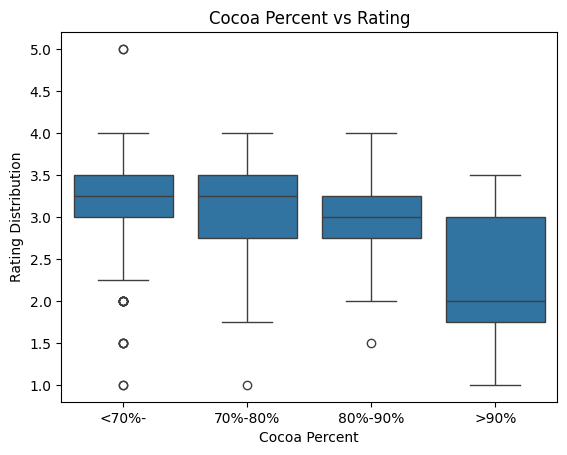

In [7]:
# YOUR CODE HERE
import seaborn as sns

x = pd.cut(df["cocoa_percent"], bins = [0, 70.0, 80.0, 90.0, np.inf], labels = ["<70%-", "70%-80%", "80%-90%", ">90%"])

plt.figure()
plt.title("Cocoa Percent vs Rating")
plt.xlabel("Cocoa Percent")
plt.ylabel("Rating Distribution")
sns.boxplot(x = x, y = "rating", data = df)
plt.show()

Top 5 bean types count for 91% of reviews.


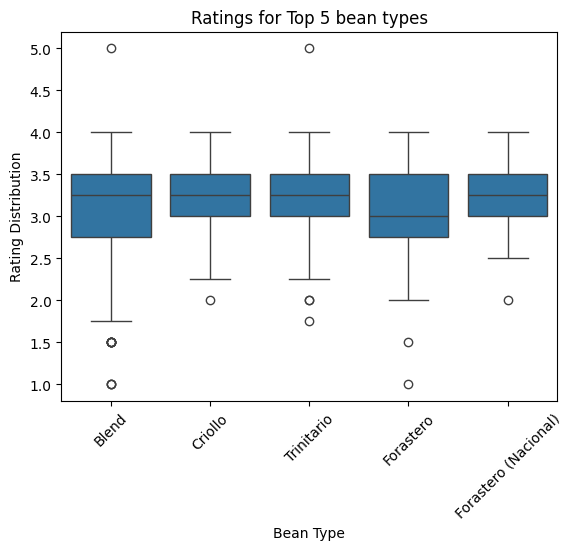

In [8]:
# What bean types are most popular in this dataset?
n = 5
print(f"Top {n} bean types count for {df['bean_type'].value_counts().head(n).sum() / df.shape[0]:.0%} of reviews.")

topN_bean_types = df["bean_type"].value_counts().head(n).index

# topN_indices = df["bean_type"].value_counts().head(5).index
plt.figure()
plt.title(f"Ratings for Top {n} bean types")
plt.xlabel("Bean Type")
plt.ylabel("Rating Distribution")
ax = sns.boxplot(x = "bean_type", y = "rating", data = df[df["bean_type"].isin(topN_bean_types.values)][["bean_type", "rating"]])
ax.set_xticks(topN_bean_types.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()


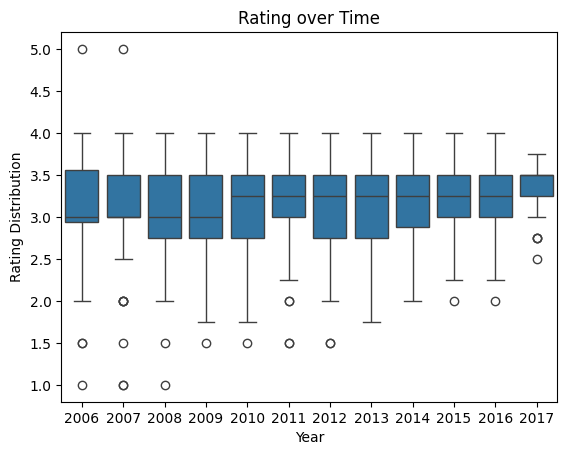

In [9]:
plt.figure()
plt.title("Rating over Time")
plt.xlabel("Year")
plt.ylabel("Rating Distribution")
sns.boxplot(x = "review_date", y = "rating", data = df)
plt.show()

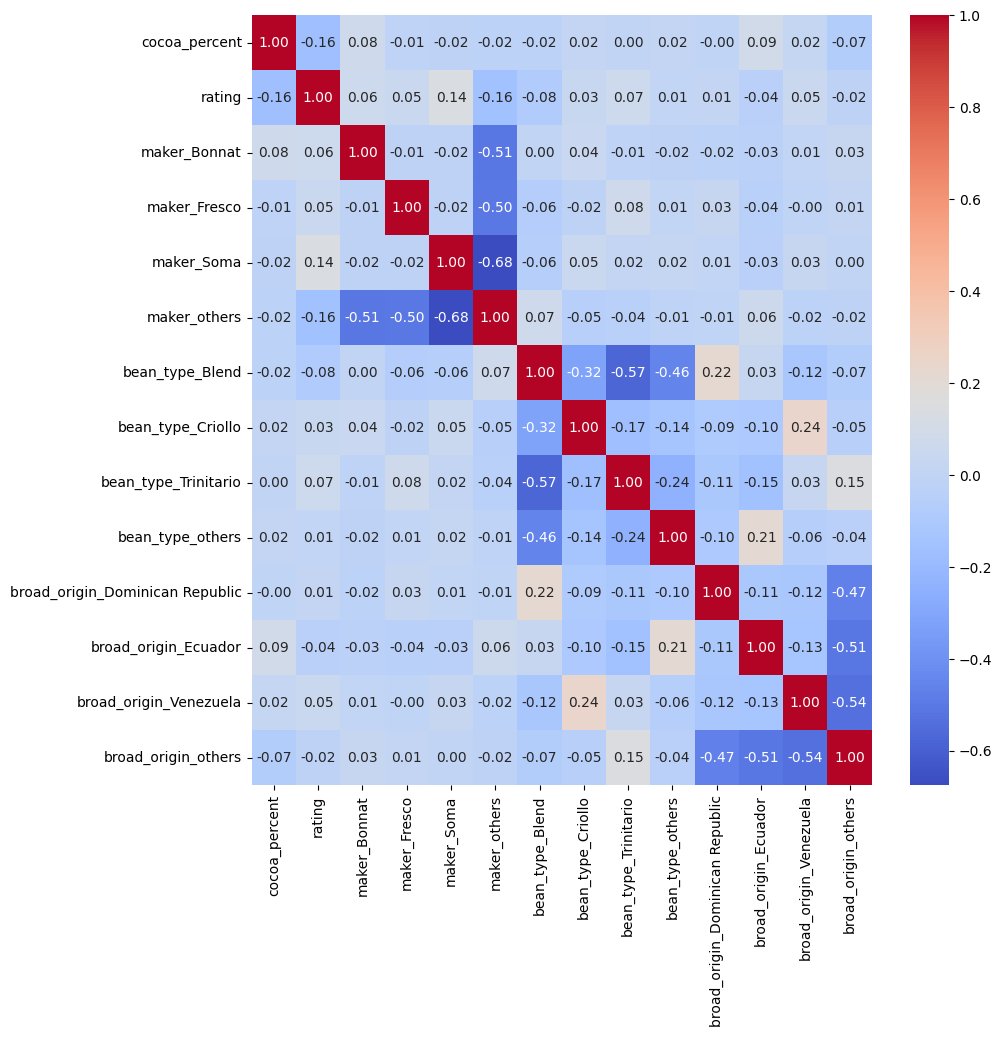

In [14]:
n = 3
topN_bean_types = df["bean_type"].value_counts().head(n).index
topN_broad_origins = df["broad_origin"].value_counts().head(n).index
topN_makers = df["maker"].value_counts().head(n).index

df2 = df[["maker", "cocoa_percent", "bean_type", "broad_origin", "rating"]].copy()
df2.loc[~df2["bean_type"].isin(topN_bean_types), "bean_type"] = "others"
df2.loc[~df2["broad_origin"].isin(topN_broad_origins), "broad_origin"] = "others"
df2.loc[~df2["maker"].isin(topN_makers), "maker"] = "others"
df2 = pd.get_dummies(df2, columns = ["maker", "bean_type", "broad_origin"])

plt.figure(figsize = (10, 10))
sns.heatmap(df2.corr(), cmap = "coolwarm", annot = True, fmt = "0.2f")
plt.show()

---
### Step 3: Data preprocessing

### <span style="color:chocolate">Exercise 4:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Identify the features of interest;
2. Perform necessary cleaning on the features;
3. Reassess the outcome variable if desired (e.g., potentially reducing the number of classes, while ensuring a minimum of 3);
4. Shuffle the dataset;
5. Create training, validation, and test datasets using a 60/20/20 split;
6. Standardize the data;
7. Integrate any supplementary tasks deemed crucial for modeling, especially considering the chosen outcome variable.

In [16]:
mapping_beans = {label: idx for idx, label in enumerate(np.unique(df.bean_type))}
mapping_label = {label: math.floor(label) - 1 for idx, label in enumerate(np.unique(df['rating']))}

In [32]:
df2 = df.copy()

In [33]:
bean_type_labels = df2["bean_type"].astype("category")
df2["bean_type_id"] = bean_type_labels.cat.codes
df2.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,bean_type_id
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,4
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,4
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,4
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,4
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,4


In [38]:
bean_type_labels.cat.categories

Index(['Amazon', 'Amazon mix', 'Amazon, ICS', 'Beniano', 'Blend',
       'Blend-Forastero,Criollo', 'CCN51', 'Criollo', 'Criollo (Amarru)',
       'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)', 'Criollo (Ocumare 77)',
       'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)',
       'Criollo, +', 'Criollo, Forastero', 'Criollo, Trinitario', 'EET',
       'Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)',
       'Forastero (Arriba) ASS', 'Forastero (Arriba) ASSS',
       'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
       'Forastero(Arriba, CCN)', 'Forastero, Trinitario', 'Matina', 'Nacional',
       'Nacional (Arriba)', 'Trinitario', 'Trinitario (85% Criollo)',
       'Trinitario (Amelonado)', 'Trinitario (Scavina)',
       'Trinitario, Forastero', 'Trinitario, Nacional', 'Trinitario, TCGA'],
      dtype='object')

In [28]:
df2 = df.copy()

# df.bean_type.map(mapping_beans)
# df.bean_type.map(mapping_beans)
df2.rating.map(mapping_label)

# df['cocoa_percent'] = df.cocoa_percent/100
# df['bean_type'] = df.bean_type.map(mapping_beans)
# df['rating'] = df.rating.map(mapping_label)

0       2
1       1
2       2
3       2
4       2
       ..
1790    2
1791    2
1792    2
1793    2
1794    2
Name: rating, Length: 1795, dtype: int64

In [27]:
# Shuffle the dataset;
df.head()
# Create training, validation, and test datasets using a 60/20/20 split


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [ ]:
# YOUR CODE HERE

---
### Step 4: Exploratory data analysis (EDA) - cont'd

### <span style="color:chocolate">Exercise 5:</span> More plots (5 points)

Conduct any further exploratory data analysis (EDA) you believe necessary to validate the successful preprocessing of the data.

In [ ]:
# YOUR CODE HERE

---
### Step 5: Modeling

### <span style="color:chocolate">Exercise 6:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [ ]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 7:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [ ]:
# YOUR CODE HERE

---
### Step 6: Hyperparameter tuning

### <span style="color:chocolate">Exercise 8:</span> Choosing hyperparameters (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [ ]:
# YOUR CODE HERE

---
### Step 7: Evaluation and generalization

### <span style="color:chocolate">Exercise 9:</span> Compute metrics (5 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [ ]:
# YOUR CODE HERE

### <span style="color:chocolate">Exercise 10:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

In [ ]:
# YOUR CODE HERE

----
### <span style="color:chocolate">Bonus question</span> (20 points)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [ ]:
# YOUR CODE HERE